/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/

The optimal number of clusters, as determined by silhouette analysis, is 3.
The silhouette score for 3 clusters is 0.9983034837265559.


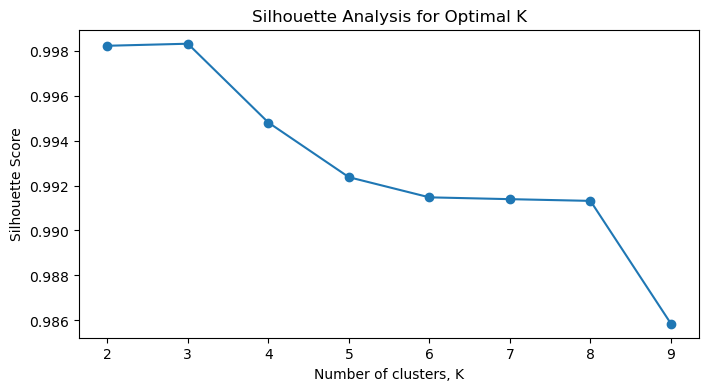

/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


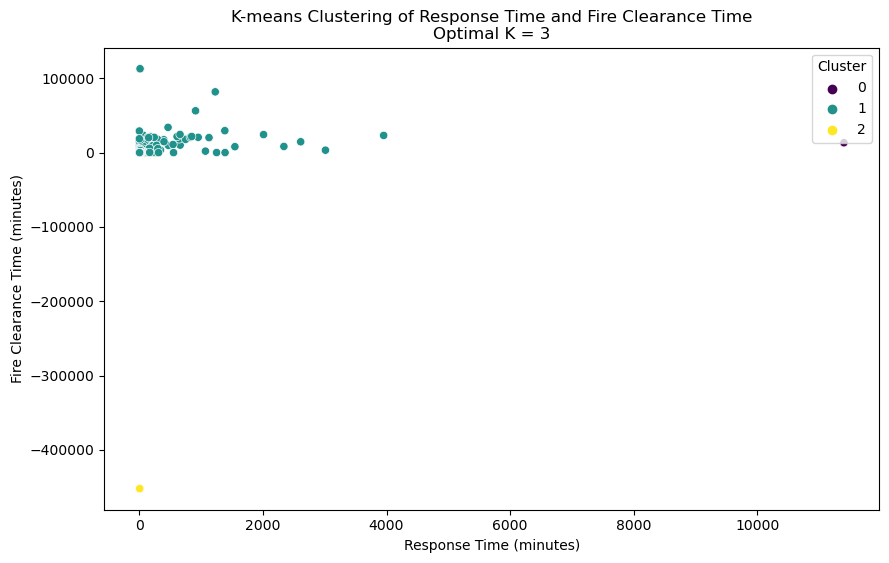

In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import dask_ml.cluster as dmlc
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sklm

# 启动或连接到已存在的Dask客户端
client = Client()

# 文件路径
filtered_data_file = 'morans_data/2021/filtered_fire_data_2021.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 使用Dask读取火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)

# 读取shapefile数据
gdf = gpd.read_file(shapefile_path)
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并数据
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca.compute(), on='FDID', how='inner')

# 删除包含缺失值的样本
merged = merged.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 采样10%的数据进行聚类分析，以提高调试速度
merged_sampled = merged.sample(frac=0.1, random_state=42)

# 选择要聚类的列
features = ['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged_sampled[features])

# 使用Silhouette Score选择最佳K值
k_range = range(2, 10)  # 从2到5个聚类

# 创建空列表来存储 SSE 和 Silhouette Score
cluster_sse_series = []
cluster_shs_series = []

for k in k_range:
    kmeans = dmlc.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)  # 首先fit数据
    clusters = kmeans.predict(data_scaled)  # 然后用predict获取聚类结果
    
    # 计算 SSE (Inertia)
    cluster_sse_series.append(kmeans.inertia_)
    
    # 计算 Silhouette Score
    silhouette_avg = sklm.silhouette_score(data_scaled, clusters)
    cluster_shs_series.append(silhouette_avg)

# 创建一个包含SSE和Silhouette Scores的报告DataFrame
report_df = pd.DataFrame({
    'K': list(k_range),
    'SSE': cluster_sse_series,
    'Silhouette Score': cluster_shs_series
})

# 找到Silhouette Score最大的K值
optimal_k_by_silhouette_score = report_df['Silhouette Score'].idxmax() + 2  # idxmax返回索引，需加上起始K值2
optimal_silhouette_score = report_df.loc[optimal_k_by_silhouette_score - 2, 'Silhouette Score']

print('The optimal number of clusters, as determined by silhouette analysis, is ' + str(optimal_k_by_silhouette_score) + ".")
print('The silhouette score for ' + str(optimal_k_by_silhouette_score) + " clusters is " + str(optimal_silhouette_score) + ".")

# 可视化 Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, cluster_shs_series, marker='o')
plt.xlabel('Number of clusters, K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.show()

# 使用最佳K值进行K-means聚类
kmeans_optimal = dmlc.KMeans(n_clusters=optimal_k_by_silhouette_score, random_state=42)
kmeans_optimal.fit(data_scaled)  # 再次fit数据
clusters_optimal = kmeans_optimal.predict(data_scaled)  # 获取最终的聚类结果

# 将聚类结果添加到原始数据中
merged_sampled['Cluster'] = clusters_optimal

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_sampled['RESPONSE_TIME'], y=merged_sampled['FIRE_CLEARANCE_TIME'], hue=merged_sampled['Cluster'], palette='viridis')
plt.title(f'K-means Clustering of Response Time and Fire Clearance Time\nOptimal K = {optimal_k_by_silhouette_score}')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Fire Clearance Time (minutes)')
plt.legend(title='Cluster')
plt.show()


In [ ]:

plt.figure(figsize=(10, 6))
plt.gca().set_xlim([0,200])
plt.gca().set_ylim([0,600])
sns.scatterplot(x=merged_sampled['RESPONSE_TIME'], y=merged_sampled['FIRE_CLEARANCE_TIME'], hue=merged_sampled['Cluster'], palette='viridis')
plt.title(f'K-means Clustering of Response Time and Fire Clearance Time\nOptimal K = {optimal_k_by_silhouette_score}')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Fire Clearance Time (minutes)')
plt.legend(title='Cluster')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取已处理的火灾数据，并设置 low_memory=False
processed_data_file = 'morans_data/2021/basicincident_processed_2021.csv'
processed_data = pd.read_csv(processed_data_file, low_memory=False)

# 确保RESPONSE_TIME和FIRE_CLEARANCE_TIME为数值类型
processed_data['RESPONSE_TIME'] = pd.to_numeric(processed_data['RESPONSE_TIME'], errors='coerce')
processed_data['FIRE_CLEARANCE_TIME'] = pd.to_numeric(processed_data['FIRE_CLEARANCE_TIME'], errors='coerce')

# 删除无法转换为数值的行
processed_data = processed_data.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 筛选出response time > 14 或 fire clearance time > 90的数据点
outlier_data = processed_data[(processed_data['RESPONSE_TIME'] > 14) | (processed_data['FIRE_CLEARANCE_TIME'] > 90)]

# 查看离散点的INC_TYPE分布
inc_type_distribution = outlier_data['INC_TYPE'].value_counts()
print("INC_TYPE Distribution for Outliers:")
print(inc_type_distribution)

# 可视化离散点的INC_TYPE分布
if not inc_type_distribution.empty:
    plt.figure(figsize=(12, 6))
    inc_type_distribution.plot(kind='bar')
    plt.title('Distribution of INC_TYPE for Outliers')
    plt.xlabel('Incident Type (INC_TYPE)')
    plt.ylabel('Count')
    plt.show()
else:
    print("No outliers found with INC_TYPE.")


INC_TYPE Distribution for Outliers:
INC_TYPE
111    7058
142    2888
143    2590
151    1861
444    1770
       ... 
443       4
115       3
430       3
110       2
164       2
Name: count, Length: 72, dtype: int64

INC_TYPE Distribution for Normal Data:
INC_TYPE
151    26429
150    14143
131    10715
444     9991
412     8564
       ...  
482       34
164       20
135        9
110        5
431        4
Name: count, Length: 71, dtype: int64


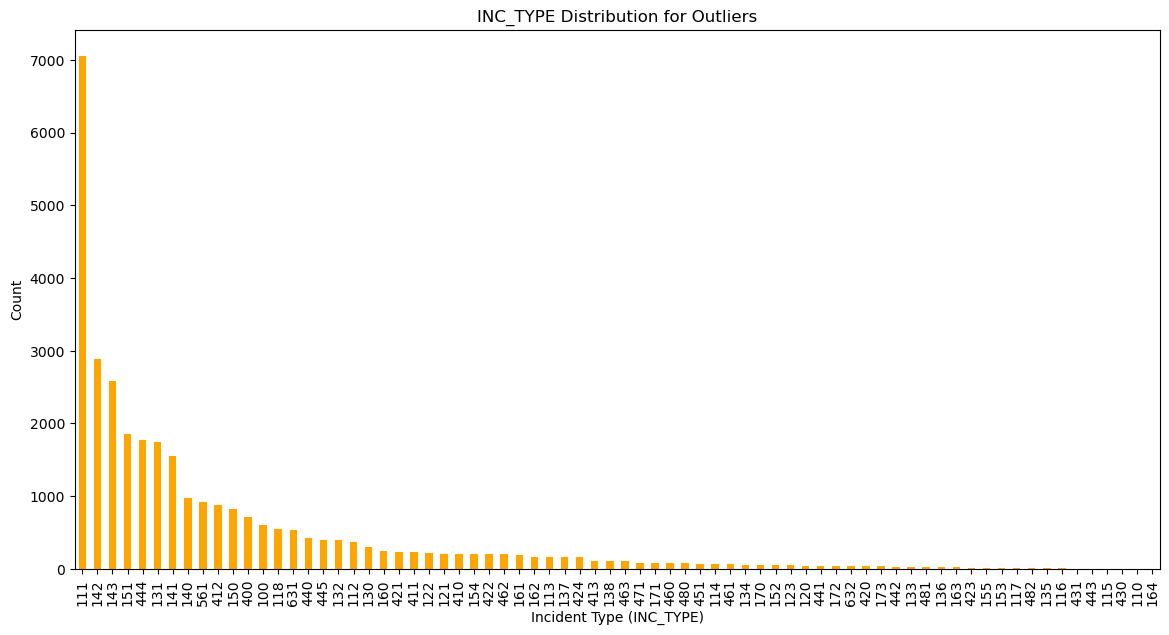

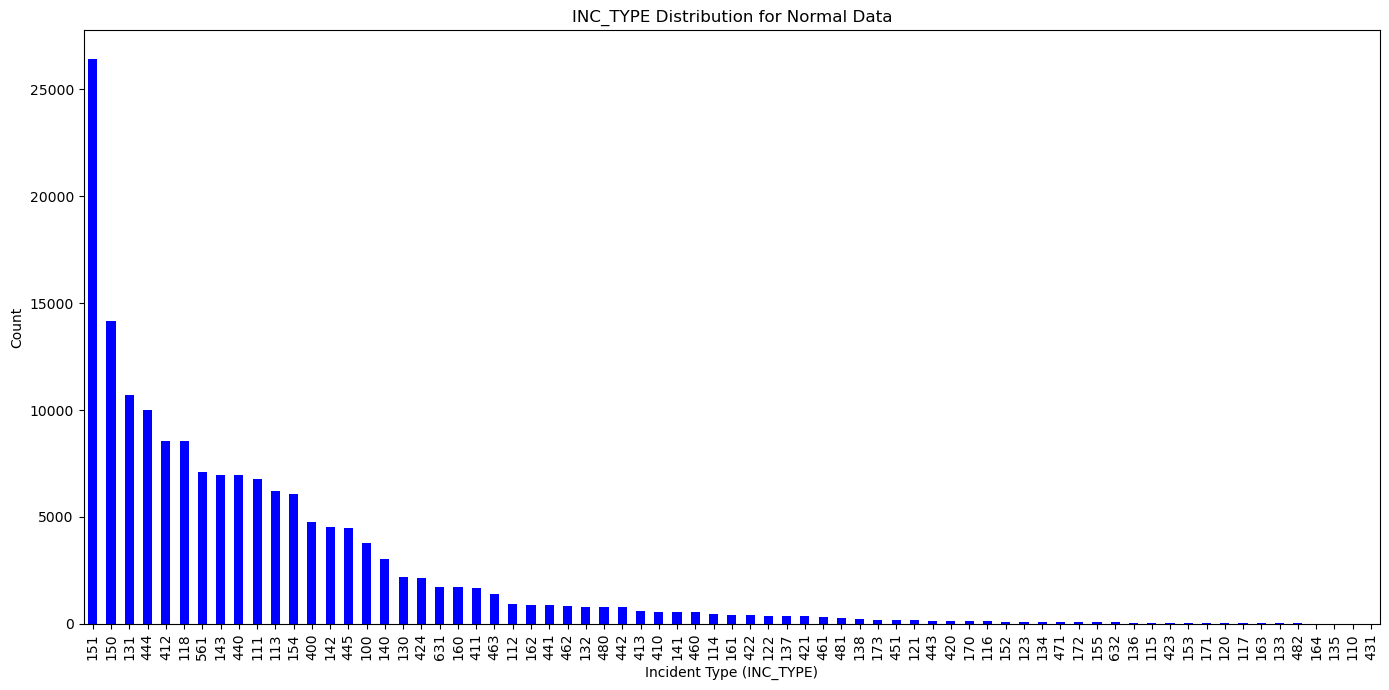

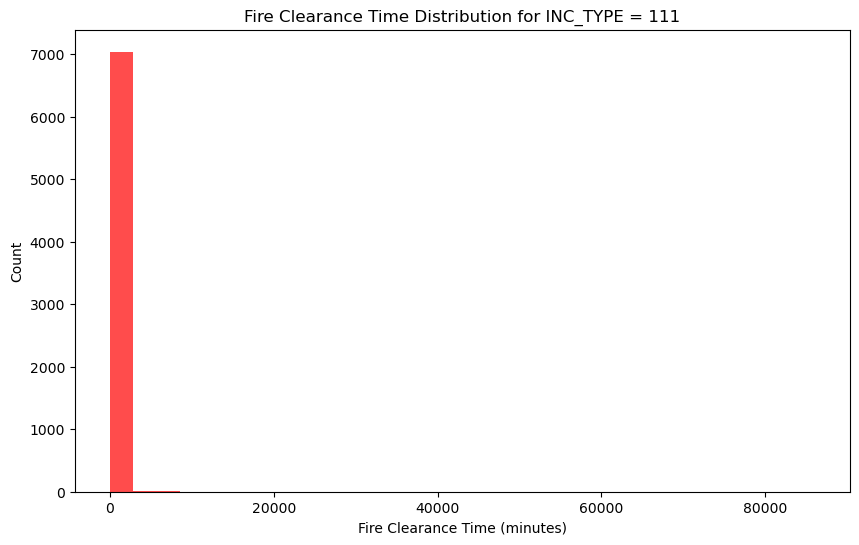

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取已处理的火灾数据
processed_data_file = 'morans_data/2021/basicincident_processed_2021.csv'
processed_data = pd.read_csv(processed_data_file, low_memory=False)

# 确保RESPONSE_TIME和FIRE_CLEARANCE_TIME为数值类型
processed_data['RESPONSE_TIME'] = pd.to_numeric(processed_data['RESPONSE_TIME'], errors='coerce')
processed_data['FIRE_CLEARANCE_TIME'] = pd.to_numeric(processed_data['FIRE_CLEARANCE_TIME'], errors='coerce')

# 删除无法转换为数值的行
processed_data = processed_data.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 筛选异常数据点：响应时间 > 14 或 清除时间 > 90
outlier_data = processed_data[(processed_data['RESPONSE_TIME'] > 14) | (processed_data['FIRE_CLEARANCE_TIME'] > 90)]

# 筛选正常数据点：响应时间 <= 14 且 清除时间 <= 90
normal_data = processed_data[(processed_data['RESPONSE_TIME'] <= 14) & (processed_data['FIRE_CLEARANCE_TIME'] <= 90)]

# 分析异常数据点的INC_TYPE分布
outlier_inc_type_distribution = outlier_data['INC_TYPE'].value_counts()
print("INC_TYPE Distribution for Outliers:")
print(outlier_inc_type_distribution)

# 分析正常数据点的INC_TYPE分布
normal_inc_type_distribution = normal_data['INC_TYPE'].value_counts()
print("\nINC_TYPE Distribution for Normal Data:")
print(normal_inc_type_distribution)

# 可视化异常数据和正常数据的INC_TYPE分布对比
plt.figure(figsize=(14, 7))


outlier_inc_type_distribution.plot(kind='bar', color='orange')
plt.title('INC_TYPE Distribution for Outliers')
plt.xlabel('Incident Type (INC_TYPE)')
plt.ylabel('Count')

plt.figure(figsize=(14, 7))
normal_inc_type_distribution.plot(kind='bar', color='blue')
plt.title('INC_TYPE Distribution for Normal Data')
plt.xlabel('Incident Type (INC_TYPE)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 深入分析高频INC_TYPE在异常数据中的表现
# 假设我们关注 INC_TYPE 为特定值的事件，如 '100' (根据实际数据情况修改)
high_freq_inc_type = outlier_inc_type_distribution.idxmax()  # 获取异常数据中出现频率最高的INC_TYPE
specific_outlier_data = outlier_data[outlier_data['INC_TYPE'] == high_freq_inc_type]

# 分析该INC_TYPE的其他特征，比如清除时间的分布
plt.figure(figsize=(10, 6))
plt.hist(specific_outlier_data['FIRE_CLEARANCE_TIME'], bins=30, color='red', alpha=0.7)
plt.title(f'Fire Clearance Time Distribution for INC_TYPE = {high_freq_inc_type}')
plt.xlabel('Fire Clearance Time (minutes)')
plt.ylabel('Count')
plt.show()


Response Time Stats:
 count    166366.000000
mean         12.454486
std         878.414895
min           0.000000
25%           4.000000
50%           6.000000
75%           8.000000
max      352807.000000
Name: RESPONSE_TIME, dtype: float64

Fire Clearance Time Stats:
 count    166366.000000
mean         86.986091
std        4521.650009
min     -452134.000000
25%           7.000000
50%          17.000000
75%          40.000000
max      220620.000000
Name: FIRE_CLEARANCE_TIME, dtype: float64


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

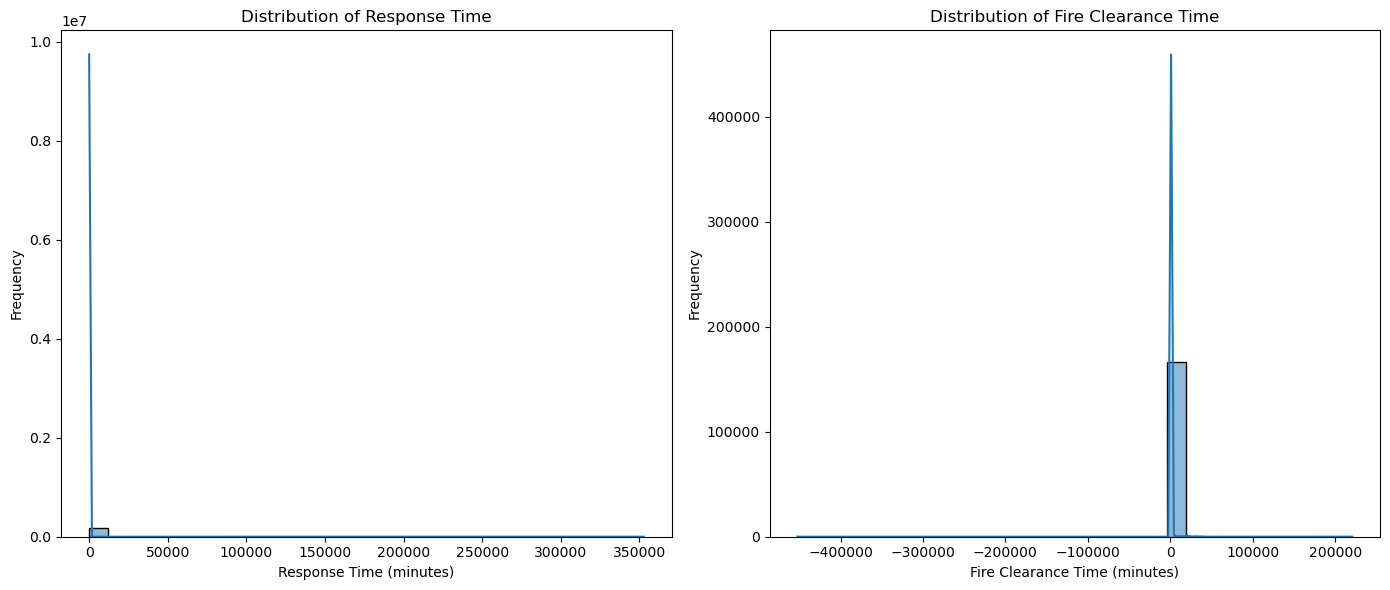

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 生成描述性统计数据
response_time_stats = merged['RESPONSE_TIME'].describe()
fire_clearance_time_stats = merged['FIRE_CLEARANCE_TIME'].describe()

print("Response Time Stats:\n", response_time_stats)
print("\nFire Clearance Time Stats:\n", fire_clearance_time_stats)

# 绘制 RESPONSE_TIME 和 FIRE_CLEARANCE_TIME 的分布图
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(merged['RESPONSE_TIME'], kde=True, bins=30)
plt.title('Distribution of Response Time')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(merged['FIRE_CLEARANCE_TIME'], kde=True, bins=30)
plt.title('Distribution of Fire Clearance Time')
plt.xlabel('Fire Clearance Time (minutes)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [3]:
# 计算1st和99th百分位数
response_time_lower = merged['RESPONSE_TIME'].quantile(0.01)
response_time_upper = merged['RESPONSE_TIME'].quantile(0.99)

fire_clearance_time_lower = merged['FIRE_CLEARANCE_TIME'].quantile(0.01)
fire_clearance_time_upper = merged['FIRE_CLEARANCE_TIME'].quantile(0.99)

# 打印计算出的范围
print("Recommended xlim (RESPONSE_TIME): [{}, {}]".format(response_time_lower, response_time_upper))
print("Recommended ylim (FIRE_CLEARANCE_TIME): [{}, {}]".format(fire_clearance_time_lower, fire_clearance_time_upper))


Recommended xlim (RESPONSE_TIME): [0.0, 37.0]
Recommended ylim (FIRE_CLEARANCE_TIME): [0.0, 591.0]


/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/

The optimal number of clusters, as determined by silhouette analysis, is 2.
The silhouette score for 2 clusters is 0.6502762141009008.


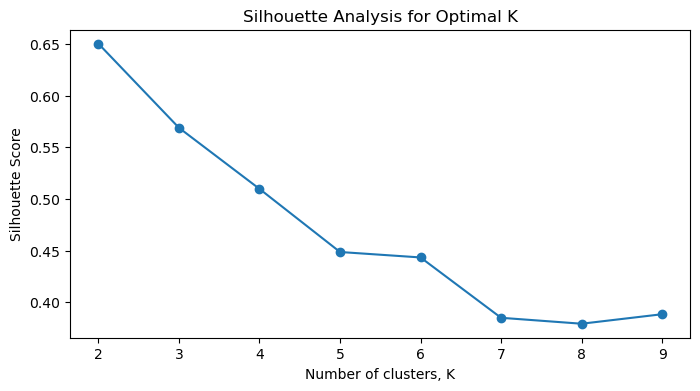

/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seab

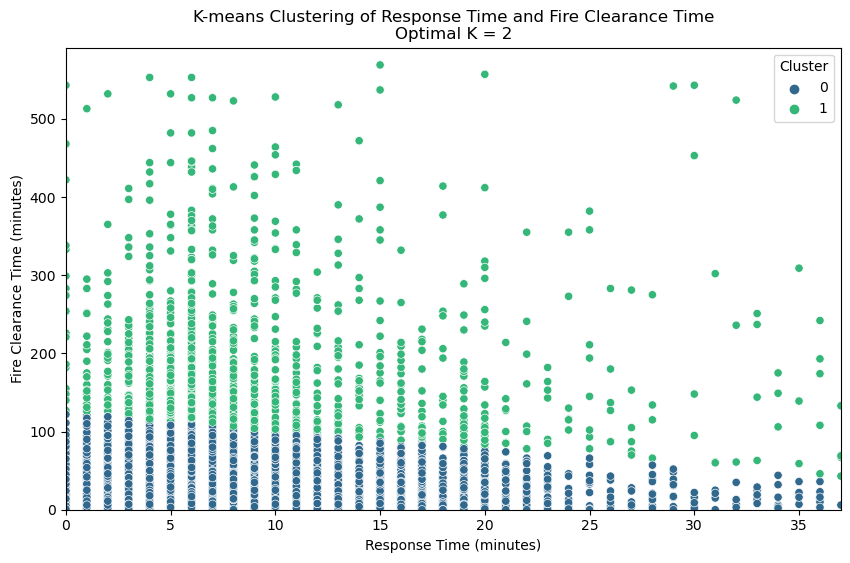

In [2]:
from dask.distributed import Client
import dask.dataframe as dd
import dask_ml.cluster as dmlc
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sklm

# 启动或连接到已存在的Dask客户端
client = Client()

# 文件路径
filtered_data_file = 'morans_data/2021/filtered_fire_data_2021.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 使用Dask读取火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)

# 读取shapefile数据
gdf = gpd.read_file(shapefile_path)
gdf['FDID'] = gdf['FDID'].astype(str)

# 合并数据
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca.compute(), on='FDID', how='inner')

# 删除包含缺失值的样本
merged = merged.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 使用推荐范围裁剪数据
xlim = [0.0, 37.0]
ylim = [0.0, 591.0]
merged = merged[(merged['RESPONSE_TIME'] >= xlim[0]) & (merged['RESPONSE_TIME'] <= xlim[1])]
merged = merged[(merged['FIRE_CLEARANCE_TIME'] >= ylim[0]) & (merged['FIRE_CLEARANCE_TIME'] <= ylim[1])]

# 采样10%的数据进行聚类分析，以提高调试速度
merged_sampled = merged.sample(frac=0.1, random_state=42)

# 选择要聚类的列
features = ['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged_sampled[features])

# 使用Silhouette Score选择最佳K值
k_range = range(2, 10)  # 从2到9个聚类

# 创建空列表来存储 SSE 和 Silhouette Score
cluster_sse_series = []
cluster_shs_series = []

for k in k_range:
    kmeans = dmlc.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)  # 首先fit数据
    clusters = kmeans.predict(data_scaled)  # 然后用predict获取聚类结果
    
    # 计算 SSE (Inertia)
    cluster_sse_series.append(kmeans.inertia_)
    
    # 计算 Silhouette Score
    silhouette_avg = sklm.silhouette_score(data_scaled, clusters)
    cluster_shs_series.append(silhouette_avg)

# 创建一个包含SSE和Silhouette Scores的报告DataFrame
report_df = pd.DataFrame({
    'K': list(k_range),
    'SSE': cluster_sse_series,
    'Silhouette Score': cluster_shs_series
})

# 找到Silhouette Score最大的K值
optimal_k_by_silhouette_score = report_df['Silhouette Score'].idxmax() + 2  # idxmax返回索引，需加上起始K值2
optimal_silhouette_score = report_df.loc[optimal_k_by_silhouette_score - 2, 'Silhouette Score']

print('The optimal number of clusters, as determined by silhouette analysis, is ' + str(optimal_k_by_silhouette_score) + ".")
print('The silhouette score for ' + str(optimal_k_by_silhouette_score) + " clusters is " + str(optimal_silhouette_score) + ".")

# 可视化 Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, cluster_shs_series, marker='o')
plt.xlabel('Number of clusters, K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.show()

# 使用最佳K值进行K-means聚类
kmeans_optimal = dmlc.KMeans(n_clusters=optimal_k_by_silhouette_score, random_state=42)
kmeans_optimal.fit(data_scaled)  # 再次fit数据
clusters_optimal = kmeans_optimal.predict(data_scaled)  # 获取最终的聚类结果

# 将聚类结果添加到原始数据中
merged_sampled['Cluster'] = clusters_optimal

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_sampled['RESPONSE_TIME'], y=merged_sampled['FIRE_CLEARANCE_TIME'], hue=merged_sampled['Cluster'], palette='viridis')
plt.xlim(xlim)
plt.ylim(ylim)
plt.title(f'K-means Clustering of Response Time and Fire Clearance Time\nOptimal K = {optimal_k_by_silhouette_score}')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Fire Clearance Time (minutes)')
plt.legend(title='Cluster')
plt.show()


/opt/conda/lib/python3.11/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seab

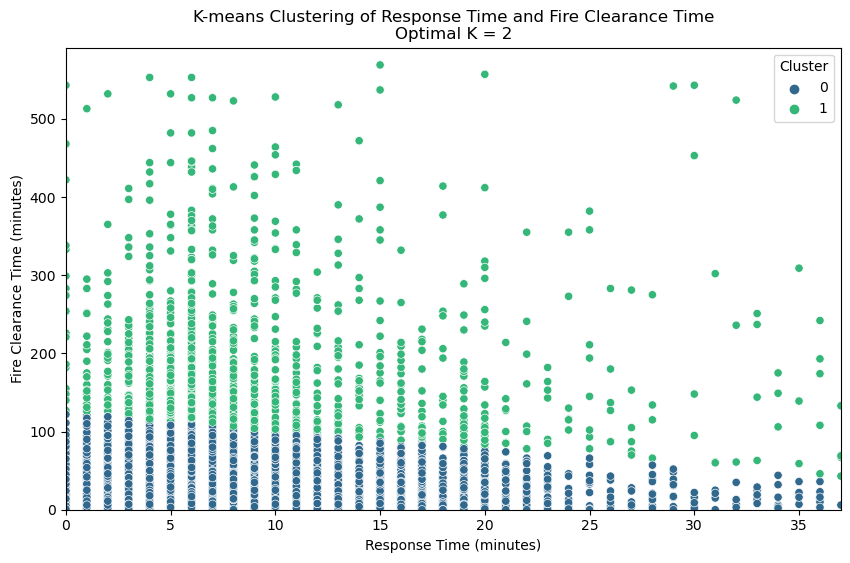

In [5]:
from dask.distributed import Client
import dask.dataframe as dd
import dask_ml.cluster as dmlc
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sklm

# 使用最佳K值进行K-means聚类
kmeans_optimal = dmlc.KMeans(n_clusters=2, random_state=42)
kmeans_optimal.fit(data_scaled)  # 再次fit数据
clusters_optimal = kmeans_optimal.predict(data_scaled)  # 获取最终的聚类结果

# 将聚类结果添加到原始数据中
merged_sampled['Cluster'] = clusters_optimal

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_sampled['RESPONSE_TIME'], y=merged_sampled['FIRE_CLEARANCE_TIME'], hue=merged_sampled['Cluster'], palette='viridis')
plt.xlim(xlim)
plt.ylim(ylim)
plt.title(f'K-means Clustering of Response Time and Fire Clearance Time\nOptimal K = {optimal_k_by_silhouette_score}')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Fire Clearance Time (minutes)')
plt.legend(title='Cluster')
plt.show()


INC_TYPE Distribution for Outliers:
INC_TYPE
141    838
142    556
111    416
143    289
140    192
      ... 
461      2
114      2
430      1
163      1
153      1
Name: count, Length: 63, dtype: int64

INC_TYPE Distribution for Normal Data:
INC_TYPE
151    28186
150    14922
111    13421
131    12370
444    11648
       ...  
164       22
135       14
110        7
431        7
430        2
Name: count, Length: 72, dtype: int64


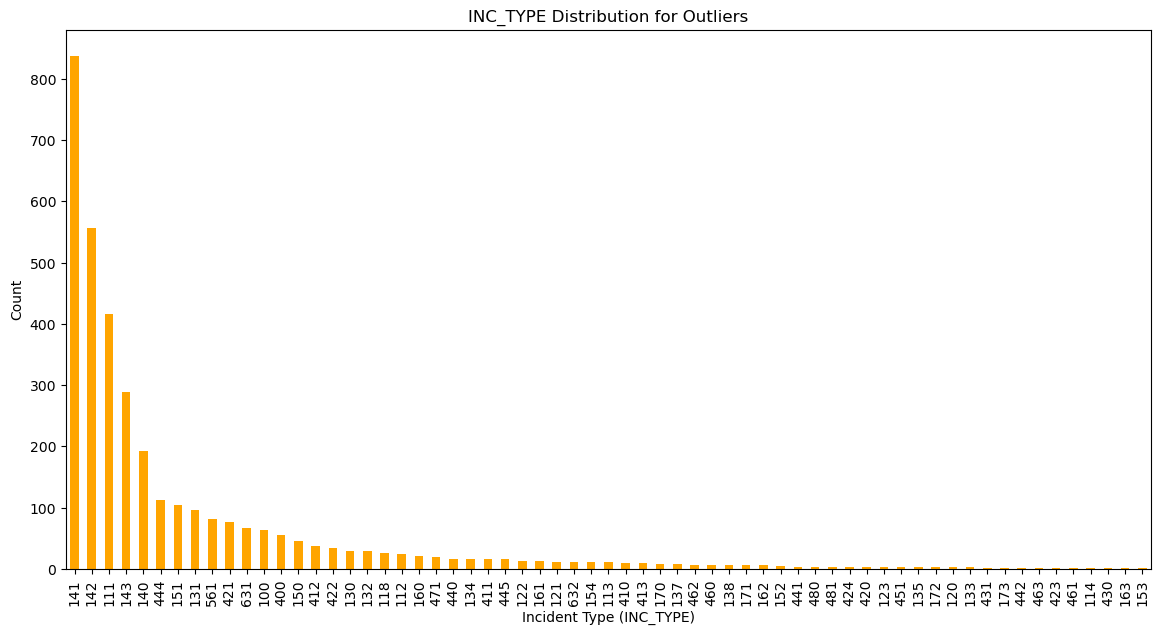

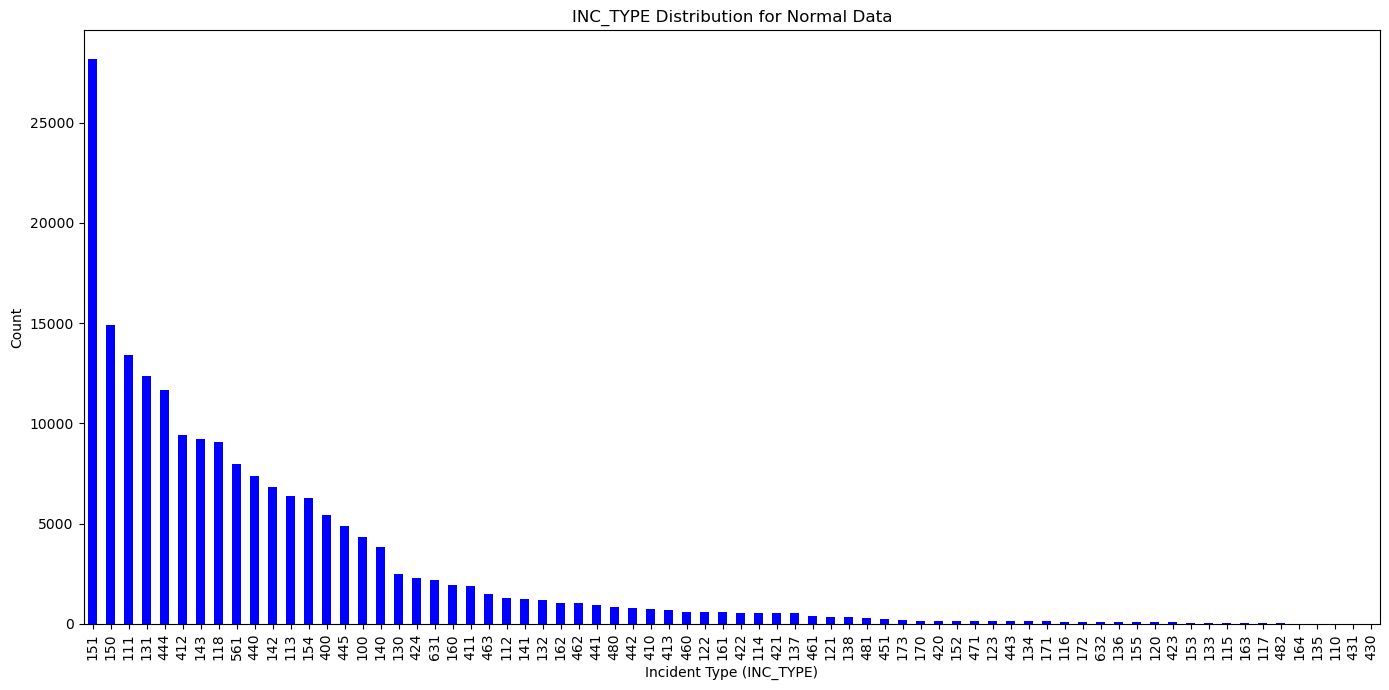

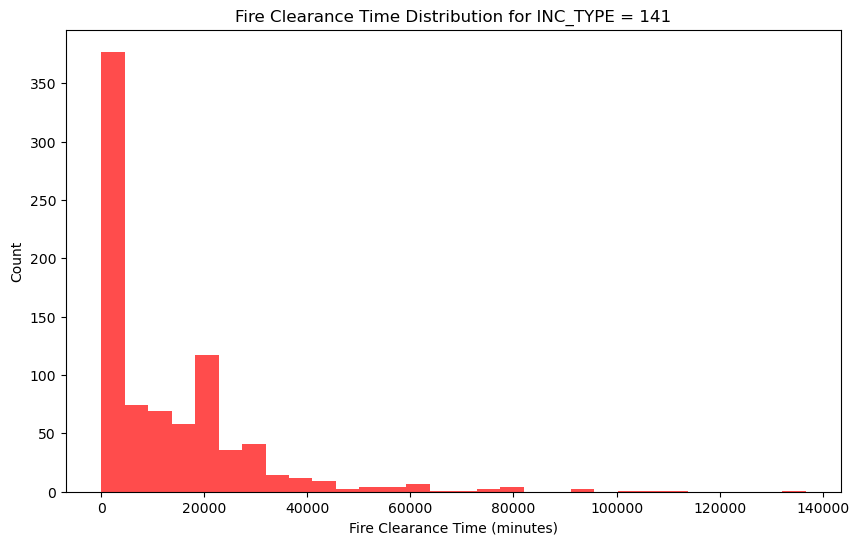

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取已处理的火灾数据
processed_data_file = 'morans_data/2021/basicincident_processed_2021.csv'
processed_data = pd.read_csv(processed_data_file, low_memory=False)

# 确保RESPONSE_TIME和FIRE_CLEARANCE_TIME为数值类型
processed_data['RESPONSE_TIME'] = pd.to_numeric(processed_data['RESPONSE_TIME'], errors='coerce')
processed_data['FIRE_CLEARANCE_TIME'] = pd.to_numeric(processed_data['FIRE_CLEARANCE_TIME'], errors='coerce')

# 删除无法转换为数值的行
processed_data = processed_data.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 筛选异常数据点：响应时间 > 14 或 清除时间 > 90
outlier_data = processed_data[(processed_data['RESPONSE_TIME'] > 34) | (processed_data['FIRE_CLEARANCE_TIME'] > 600)]

# 筛选正常数据点：响应时间 <= 14 且 清除时间 <= 90
normal_data = processed_data[(processed_data['RESPONSE_TIME'] <= 34) & (processed_data['FIRE_CLEARANCE_TIME'] <= 600)]

# 分析异常数据点的INC_TYPE分布
outlier_inc_type_distribution = outlier_data['INC_TYPE'].value_counts()
print("INC_TYPE Distribution for Outliers:")
print(outlier_inc_type_distribution)

# 分析正常数据点的INC_TYPE分布
normal_inc_type_distribution = normal_data['INC_TYPE'].value_counts()
print("\nINC_TYPE Distribution for Normal Data:")
print(normal_inc_type_distribution)

# 可视化异常数据和正常数据的INC_TYPE分布对比
plt.figure(figsize=(14, 7))


outlier_inc_type_distribution.plot(kind='bar', color='orange')
plt.title('INC_TYPE Distribution for Outliers')
plt.xlabel('Incident Type (INC_TYPE)')
plt.ylabel('Count')

plt.figure(figsize=(14, 7))
normal_inc_type_distribution.plot(kind='bar', color='blue')
plt.title('INC_TYPE Distribution for Normal Data')
plt.xlabel('Incident Type (INC_TYPE)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 深入分析高频INC_TYPE在异常数据中的表现
# 假设我们关注 INC_TYPE 为特定值的事件，如 '100' (根据实际数据情况修改)
high_freq_inc_type = outlier_inc_type_distribution.idxmax()  # 获取异常数据中出现频率最高的INC_TYPE
specific_outlier_data = outlier_data[outlier_data['INC_TYPE'] == high_freq_inc_type]

# 分析该INC_TYPE的其他特征，比如清除时间的分布
plt.figure(figsize=(10, 6))
plt.hist(specific_outlier_data['FIRE_CLEARANCE_TIME'], bins=30, color='red', alpha=0.7)
plt.title(f'Fire Clearance Time Distribution for INC_TYPE = {high_freq_inc_type}')
plt.xlabel('Fire Clearance Time (minutes)')
plt.ylabel('Count')
plt.show()
